# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import pickle

from qiskit import *
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)


C:\Users\amrit\AppData\Local\Temp/ipykernel_24436/334674113.py:9: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,


In [2]:
import rotcounterrot as rcr
#import vqe
import zne
from zne import *

# Setup

In [3]:
token = ''  # Put in your IBM token
#IBMQ.save_account(token, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

In [4]:
backend_sim = 'ibmq_qasm_simulator'
backends = ["ibmq_manila", "ibmq_quito", "ibmq_belem", "ibmq_lima", "ibm_oslo", "ibm_nairobi"]

job_manager = IBMQJobManager()
backend_name = backends[0]      # Either use backend_sim for simulator, or backends[x] for device
backend = provider.get_backend(backend_name) 
print(backend)

n_qubits = 4
best_qubits = [1,2,3,4]  # A list of four (linearly connected) qubits
shots_num = 8000
beta = np.pi/2

ibmq_manila


# Running the Rotation-Counter Rotation Experiment

In [5]:
# Coefficients of T operator
acoeff_load = np.load("Re1_L4.npy")  # or np.genfromtxt("")
bcoeff_load = np.load("ReX_L4.npy")  # or np.genfromtxt("")

In [6]:
# Cell for reducing number of points for quicker tests
# start:stop:step
acoeff_ar = acoeff_load[0:200:10]
bcoeff_ar = bcoeff_load[0:200:10]

assert len(acoeff_ar)==len(bcoeff_ar), "Length of coefficient arrays dont match"

num_coeff = len(acoeff_ar)
print(num_coeff)

 

20


#### Parameters for ZNE

In [7]:
# scale factors representing how many times CNOTs are repeated
# must be list of odd positive integers
scale_factors = [1,3,5,7]
num_sf = len(scale_factors)

# Choose if and how many times you want to repeat your circuits for error estimate
repeat_circs = False #### set to true if you want to repeat your experiments for mean and std
# Initialize num_reps to 1
num_reps = 1
# Change num_reps to chosen value for repeating circuits
if repeat_circs:
    num_reps = 5


fit_types = ["expquadlin", "expquad", "quadratic", "exponential"]

#### Building Circuits List

In [8]:
# circuits for all a and b coefficients and scale factors
circ_list_sf = rcr.generate_circuits_zne(beta, acoeff_ar, bcoeff_ar, scale_factors)

circ_list_final = zne.repeat_circuits(circ_list_sf, num_reps)

#### Run circuit list with and without readout error mitigation

In [9]:
res_list, mit_res_list, meas_fitter = zne.ibmq_executor_results_meascal(n_qubits, circ_list_final, backend, job_manager, shots=shots_num, layout=best_qubits)

===== Measurement Error Calibration =====
Job Status: job has successfully run
Measurement Calibration jobs have finished.
========= Experiment Jobs ==========
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
All jobs have finished.


#### Getting logicX and logicXerr values from counts

In [10]:
X_mit, Xerr_mit, df_mitres = zne.rcr_X_from_counts(mit_res_list, beta, acoeff_ar, bcoeff_ar, num_sf, num_reps)
X_raw, Xerr_raw, df_rawres = zne.rcr_X_from_counts(res_list, beta, acoeff_ar, bcoeff_ar, num_sf, num_reps)

#### Getting mean and std corresponding to repeat_circs from the expectation values

In [11]:
if repeat_circs:
    X_raw_mean = np.mean(X_raw, axis=2)
    X_raw_std = np.std(X_raw, axis=2)
    X_mit_mean = np.mean(X_mit, axis=2)
    X_mit_std = np.std(X_mit, axis=2)

#### Extrapolation according to fit_types

In [12]:
# initialize array for storing extrapolated values
# initialize arrays for storing fit parameters and their standard deviations
if "linear" in fit_types:
    X0_l = np.zeros((num_coeff,2)) # 1st row for raw, 2nd row for mit 
    popt_l = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for params_linear
    pstd_l = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for param errs

if "quadratic" in fit_types:
    X0_q = np.zeros((num_coeff,2)) # 1st row for raw, 2nd row for mit 
    popt_q = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for params_quadratic
    pstd_q = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for param errs
    
if "exponential" in fit_types:
    X0_e = np.zeros((num_coeff,2)) # 1st row for raw, 2nd row for mit 
    popt_e = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for params_exponential
    pstd_e = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for param errs

if "tanh" in fit_types:
    X0_t = np.zeros((num_coeff,2)) # 1st row for raw, 2nd row for mit
    popt_t = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for params_tanh
    pstd_t = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for param errs

if "expquad" in fit_types:
    X0_eq = np.zeros((num_coeff,2)) # 1st row for raw, 2nd row for mit 
    popt_eq = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for params_exponential
    pstd_eq = np.zeros((num_coeff,2,2)) # 2nd index for raw/mit and 3rd index for param errs

if "expquadlin" in fit_types:
    X0_el = np.zeros((num_coeff,2)) # 1st row for raw, 2nd row for mit 
    popt_el = np.zeros((num_coeff,2,3)) # 2nd index for raw/mit and 3rd index for params_exponential
    pstd_el = np.zeros((num_coeff,2,3)) # 2nd index for raw/mit and 3rd index for param errs


# expectation value of X without any error mitigation
X0_raw = X_raw[0,:]
# expectation value of X with only measurement error mitigation
X0_mit = X_mit[0,:]


xdata = np.array(scale_factors)

pr = False
for i in range(num_coeff):
    #print(f'Fitting for i = {i}=================')
    y_raw = X_raw[:,i]
    y_mit = X_mit[:,i]
    if repeat_circs:
        sigma_raw = X_raw_std[:,i]
        sigma_mit = X_mit_std[:,i]
    else:
        sigma_raw = None
        sigma_mit = None

    # linear fit and updating values
    if "linear" in fit_types:
        x0_l_raw, popt_l_raw, pcov_l_raw = zne.extrapolate_res(linear, xdata, y_raw, sigma=sigma_raw)
        x0_l_mit, popt_l_mit, pcov_l_mit = zne.extrapolate_res(linear, xdata, y_mit, sigma=sigma_mit)
        X0_l[i,0] = x0_l_raw
        X0_l[i,1] = x0_l_mit
        popt_l[i,0,:] = popt_l_raw
        popt_l[i,1,:] = popt_l_mit
        pstd_l[i,0,:] = np.sqrt(np.diag(pcov_l_raw))
        pstd_l[i,1,:] = np.sqrt(np.diag(pcov_l_mit))
        if pr: print("Linear fit completed")
    
    # quadratic fit and updating values
    if "quadratic" in fit_types:
        x0_q_raw, popt_q_raw, pcov_q_raw = zne.extrapolate_res(quadratic, xdata, y_raw, sigma=sigma_raw)
        x0_q_mit, popt_q_mit, pcov_q_mit = zne.extrapolate_res(quadratic, xdata, y_mit, sigma=sigma_mit)
        X0_q[i,0] = x0_q_raw
        X0_q[i,1] = x0_q_mit
        popt_q[i,0,:] = popt_q_raw
        popt_q[i,1,:] = popt_q_mit
        pstd_q[i,0,:] = np.sqrt(np.diag(pcov_q_raw))
        pstd_q[i,1,:] = np.sqrt(np.diag(pcov_q_mit))
        if pr: print("Quadratic fit completed")
  
    # tanh fit and updating values
    if "tanh" in fit_types:
        x0_t_raw, popt_t_raw, pcov_t_raw = zne.extrapolate_res(tanhyp, xdata, y_raw, sigma=sigma_raw)
        x0_t_mit, popt_t_mit, pcov_t_mit = zne.extrapolate_res(tanhyp, xdata, y_mit, sigma=sigma_mit)
        X0_t[i,0] = x0_t_raw
        X0_t[i,1] = x0_t_mit
        popt_t[i,0,:] = popt_t_raw
        popt_t[i,1,:] = popt_t_mit
        pstd_t[i,0,:] = np.sqrt(np.diag(pcov_t_raw))
        pstd_t[i,1,:] = np.sqrt(np.diag(pcov_t_mit))
        if pr: print("Tanh fit completed")
    
    # exponential fit and updating values
    if "exponential" in fit_types:
        x0_e_raw, popt_e_raw, pcov_e_raw = zne.extrapolate_res(expfit2, xdata, y_raw, sigma=sigma_raw)
        x0_e_mit, popt_e_mit, pcov_e_mit = zne.extrapolate_res(expfit2, xdata, y_mit, sigma=sigma_mit)
        X0_e[i,0] = x0_e_raw
        X0_e[i,1] = x0_e_mit
        popt_e[i,0,:] = popt_e_raw
        popt_e[i,1,:] = popt_e_mit
        pstd_e[i,0,:] = np.sqrt(np.diag(pcov_e_raw))
        pstd_e[i,1,:] = np.sqrt(np.diag(pcov_e_mit))
        if pr: print("Exponential fit completed")
        
    # exponential fit and updating values
    if "expquad" in fit_types:
        x0_eq_raw, popt_eq_raw, pcov_eq_raw = zne.extrapolate_res(expquadfit, xdata, y_raw, sigma=sigma_raw)
        x0_eq_mit, popt_eq_mit, pcov_eq_mit = zne.extrapolate_res(expquadfit, xdata, y_mit, sigma=sigma_mit)
        X0_eq[i,0] = x0_eq_raw
        X0_eq[i,1] = x0_eq_mit
        popt_eq[i,0,:] = popt_eq_raw
        popt_eq[i,1,:] = popt_eq_mit
        pstd_eq[i,0,:] = np.sqrt(np.diag(pcov_eq_raw))
        pstd_eq[i,1,:] = np.sqrt(np.diag(pcov_eq_mit))
        if pr: print("Gaussian fit completed")
       
    # exponential fit and updating values
    if "expquadlin" in fit_types:
        x0_el_raw, popt_el_raw, pcov_el_raw = zne.extrapolate_res(expquadlinfit, xdata, y_raw, sigma=sigma_raw)
        x0_el_mit, popt_el_mit, pcov_el_mit = zne.extrapolate_res(expquadlinfit, xdata, y_mit, sigma=sigma_mit)
        X0_el[i,0] = x0_el_raw
        X0_el[i,1] = x0_el_mit
        popt_el[i,0,:] = popt_el_raw
        popt_el[i,1,:] = popt_el_mit
        pstd_el[i,0,:] = np.sqrt(np.diag(pcov_el_raw))
        pstd_el[i,1,:] = np.sqrt(np.diag(pcov_el_mit))
        if pr: print("ExpQuadLin fit completed")

c:\Users\amrit\.conda\envs\qiskit_env\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


#### Parameters used to save data or figs

In [13]:
now = datetime.now()
date = now.strftime("%d_%m")
exp_num = now.strftime("%H")


### Saving data

In [14]:
savefile = True
# save the counts as csv
if savefile:
    df_rawres.to_csv(date + "_exp" + exp_num + '_' + backend_name + "_rawres.csv")
    df_mitres.to_csv(date + "_exp" + exp_num + '_' + backend_name + "_mitres.csv")
    

In [21]:
#dictionary with configurations and results to be saved as pickle file

if savefile:
    file_dict = {}
    
    # backend info
    file_dict['backend_name'] = backend_name
    
    # experiment parameters
    file_dict['n_qubits'] = n_qubits
    file_dict['best_qubits'] = best_qubits
    file_dict['shots_num'] = shots_num
    file_dict['scale_factors'] = scale_factors
    file_dict['repeat_circs'] = repeat_circs

    file_dict["acoeff_ar"] = acoeff_ar
    file_dict["bcoeff_ar"] = bcoeff_ar
     
    # results
    file_dict['meas_fitter'] = meas_fitter
    file_dict['X_raw'] = X_raw
    file_dict['X_mit'] = X_mit
    file_dict['Xerr_raw'] = Xerr_raw
    file_dict['Xerr_mit'] = Xerr_mit
    
    file_dict['X0_raw'] = X0_raw
    file_dict['X0_mit'] = X0_mit
    
    if repeat_circs:
        file_dict['X_raw_mean'] = X_raw_mean
        file_dict['X_mit_mean'] = X_mit_mean
        file_dict['X_raw_std'] = X_raw_std
        file_dict['X_mit_std'] = X_mit_std
    
    
    file_dict['fit_types'] = fit_types
    
    if "linear" in fit_types:
        file_dict['X0_l'] = X0_l
        file_dict['popt_l'] = popt_l
        file_dict['pstd_l'] = pstd_l
    
    if "quadratic" in fit_types:
        file_dict['X0_q'] = X0_q
        file_dict['popt_q'] = popt_q
        file_dict['pstd_q'] = pstd_q

    if "tanh" in fit_types:
        file_dict['X0_t'] = X0_t
        file_dict['popt_t'] = popt_t
        file_dict['pstd_t'] = pstd_t
    
    if "exponential" in fit_types:
        file_dict['X0_e'] = X0_e
        file_dict['popt_e'] = popt_e
        file_dict['pstd_e'] = pstd_e
    
    if "expquad" in fit_types:
        file_dict['X0_eq'] = X0_e
        file_dict['popt_eq'] = popt_eq
        file_dict['pstd_eq'] = pstd_eq
    
    if "expquadlin" in fit_types:
        file_dict['X0_el'] = X0_el
        file_dict['popt_el'] = popt_el
        file_dict['pstd_el'] = pstd_el


    fname_data = date + "_exp" + exp_num + '_' + backend_name + "_zne_data.p"
    pickle.dump(file_dict, open(fname_data, "wb"))

### Loading data (Set load=True, backend, date and exp_num to load previously saved data,...
### SET LOAD=FALSE OTHERWISE)

In [32]:
load = True

def extract_vars(data_dict, pr=True):
    # extract all keys from dict as global variables
    
    var_names = data_dict.keys()
    
    if pr: print("\033[1m"+"Variable names:"+"\033[0m")
    for var in var_names:
        globals()[var] = data_dict[var]
        if pr: print(var)
    
    return var_names


if load:
    backend_name = 'ibmq_manila'
    date = '18_09'
    exp_num = '23'
    
    fname_load = date + "_exp" + exp_num + '_' + backend_name + "_zne_data.p"

    reader = open(fname_load,'rb')
    data_dict = pickle.load(reader)

    var_names = extract_vars(data_dict, pr=True)
    
    if repeat_circs:
        df_rawres = pd.read_csv(date + "_exp" + exp_num + '_' + backend_name + "_rawres.csv", header=[0,1,2], 
                                dtype={('step','sf_ind','coeff_ind','rep_num'):str})
        df_mitres = pd.read_csv(date + "_exp" + exp_num + '_' + backend_name + "_mitres.csv", header=[0,1,2], 
                                dtype={('step','sf_ind','coeff_ind','rep_num'):str})
    else:
        df_rawres = pd.read_csv(date + "_exp" + exp_num + '_' + backend_name + "_rawres.csv", header=[0,1,2], 
                                dtype={('step','sf_ind','coeff_ind'):str})
        df_mitres = pd.read_csv(date + "_exp" + exp_num + '_' + backend_name + "_mitres.csv", header=[0,1,2], 
                                dtype={('step','sf_ind','coeff_ind'):str})
    
    

Variable names:
backend_name
n_qubits
best_qubits
shots_num
scale_factors
repeat_circs
acoeff_ar
bcoeff_ar
meas_fitter
X_raw
X_mit
Xerr_raw
Xerr_mit
X0_raw
X0_mit
fit_types
X0_q
popt_q
pstd_q
X0_e
popt_e
pstd_e
X0_eq
popt_eq
pstd_eq
X0_el
popt_el
pstd_el


### Plotting

In [33]:
alpha_ar = np.linspace(0, np.pi/2, len(acoeff_ar))

print(Xerr_mit[0,:]-X0_mit)


[-0.85630582 -0.84009285 -0.85264524 -0.84032685 -0.80805715 -0.78321772
 -0.77163151 -0.72444644 -0.6876586  -0.64975147 -0.61065536 -0.54968847
 -0.52167109 -0.46638106 -0.39670585 -0.32710389 -0.26958375 -0.18678325
 -0.118638   -0.05754869]


In [34]:
#other_data = np.genfromtxt('', delimiter=',')

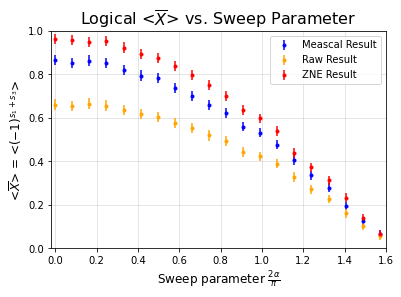

In [35]:
savefig = True
errorbar = True

if errorbar:
    plt.errorbar(alpha_ar, X0_mit, yerr = 2*Xerr_mit[0,:], fmt = "o",color = "blue", markersize=3, label = "Meascal Result")
    plt.errorbar(alpha_ar, X0_raw, yerr = 2*Xerr_raw[0,:], fmt = "o",color = "orange", markersize=3, label = "Raw Result")
    plt.errorbar(alpha_ar, X0_e[:,1], yerr = 2*Xerr_mit[0,:], fmt = "o",color = "red", markersize=3, label = "ZNE Result")
else:
    plt.plot(alpha_ar, X0_mit, "o",color = "blue", markersize=3, label = "Meascal Result")
    plt.plot(alpha_ar, X0_raw, "o",color = "orange", markersize=3, label = "Raw Result")
    plt.plot(alpha_ar, X0_e[:,1], "o",color = "red", markersize=3, label = "ZNE Result")

# plt.plot(alpha_ar, other_data, "r-", label="Theory result")
plt.legend()
plt.title(r"Logical <$\overline{X}$> vs. Sweep Parameter", size = 16)
plt.xlabel(r"Sweep parameter $\frac{2\alpha}{\pi}$", size = 12)
plt.ylabel(r"<$\overline{X}$> = <$(-1)^{s_1 + s_3}$>", size = 12)
plt.ylim(0,1)
plt.xlim(-0.02,1.6)
plt.grid(alpha=0.4)
# plt.savefig()

if savefig:
    fname_str = "rcr_Xalpha_" + date + "_exp" + exp_num + '_' + backend_name + ".pdf"
    plt.savefig(fname_str)

plt.show()

# Running VQE

In [ ]:
theta_ar = np.linspace(0, np.pi/4, 100)

Note: If just using the raw VQE data, then only $0 \leq \theta \leq \pi/4$ is required. If planning to do Fourier sum fits to the VQE data, then $0 \leq \theta \leq \pi/2$ for $\langle K_i \rangle$ and $0 \leq \theta \leq \pi$ for $\langle X_i \rangle$ should be used to capture a full period.

In [ ]:
best_qubits_one = [0]  # A list containing the position of the best single qubit
best_qubits_three = [0,1,2]  # A list containing the postion of the best linearly connected three qubits
shots_num = 8000

#### Get circuits for K

In [ ]:
circ_3q_K = vqe.ciruits_avgK_3q(theta, scale_factors)

#### Run circuits for K

In [ ]:
res_list_K, mit_res_list_K, meas_fitter_K = zne.ibmq_executor_results_meascal(circ_3q_K, backend, job_manager, layout=best_qubits_three)

### Running VQE without measurment error mitigation

In [ ]:
Xavg_ar, Xerr_ar = vqe.multiple_avgX(backend, best_qubits_one, shots_num, job_manager, theta_ar)

In [ ]:
Kavg_ar, Kerr_ar = vqe.multiple_avgK_1q(backend, best_qubits_one, best_qubits_three, shots_num, job_manager, theta_ar)

### Running VQE with measurement error mitigation

In [ ]:
meas_filter_one = rcr.run_meas_error_calibs(backend, best_qubits_one, shots_num)

In [ ]:
# meas_filter_three = rcr.run_meas_error_calibs(backend, best_qubits_three, shots_num)

In [ ]:
Xavg_ar, Xerr_ar = vqe.multiple_avgX(backend, best_qubits_one, shots_num, job_manager, theta_ar, meas_filter_one)

In [ ]:
Kavg_ar, Kerr_ar = vqe.multiple_avgK(backend, best_qubits_one, best_qubits_three, shots_num, job_manager, theta_ar, meas_filter_one, meas_filter_three)

### Saving data

In [ ]:
np.savetxt("", Xavg_ar, delimiter=",")
np.savetxt("", Xerr_ar, delimiter=",")
np.savetxt("", Kavg_ar, delimiter=",")
np.savetxt("", Kerr_ar, delimiter=",")

# Getting Coefficients from VQE

In [ ]:
alpha_ar = np.linspace(0, np.pi/2, 100)

### Direct Calculation

In [ ]:
thetamin_raw_ar = vqe.multiple_get_thetamin_VQE(alpha_ar, theta_ar, Xavg_ar, Kavg_ar)
acoeff_ar, bcoeff_ar = vqe.getT_VQE(thetamin_raw_ar)

### Calculation with Fourier Fits

In [ ]:
maxn = 50

In [ ]:
Xfouriercoeff_ar = vqe.mult_fouriercoeff(theta_ar, np.pi, maxn, Xavg_ar)
Kfouriercoeff_ar = vqe.mult_fouriercoeff(theta_ar, np.pi/2, maxn, Kavg_ar)

In [ ]:
Xapprox_ar = vqe.fourierfit(theta_ar, [1, 3, 5, 7, 9], Xfouriercoeff_ar)
Kapprox_ar = vqe.fourierfit(theta_ar, [0, 2, 4, 6, 8], Kfouriercoeff_ar)#

Note that $\langle X_i \rangle$ is an odd function of $\theta$ and $\langle K_i \rangle$ is an even function of $\theta$. So, when calculating the fourier sum approximation, we can be selective with the coefficients. Also, the fourier sum is better truncated before the coeffficients get too high, wherin the fit will add back the experimental noise (of which the removal is the entire point of the fourier fitting). A plot of the magnitude of the coefficients can be done to see at what point they drop off and hence can be neglected in the fit.

In [ ]:
thetamin_approx_ar = vqe.multiple_get_thetamin_VQE(alpha_ar, theta_ar, Xapprox_ar, Kapprox_ar)
acoeff_ar, bcoeff_ar = vqe.getT_VQE(thetamin_ar)

### Analytic Result

In [ ]:
Xavg_analytic_ar = vqe.predictedX(theta_ar)
Kavg_analytic_ar = vqe.predictedK(theta_ar)

thetamin_analytic_ar = vqe.multiple_get_thetamin_VQE(alpha_ar, theta_ar, Xavg_analytic_ar, Kavg_analytic_ar)
acoeff_ar, bcoeff_ar = vqe.getT_VQE(thetamin_analytic_ar)

## Saving Results

In [ ]:
np.savetxt("", acoeff_ar, delimiter=",")
np.savetxt("", bcoeff_ar, delimiter=",")